# Sensitivity analysis for synaptic input parameters

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sim.nwbio as nwbio

import key_parser as ks
import preprocessing

In [21]:
# file names
fr =  [ nwbio.FileReader('nsyn_%d.nwb' % i) for i in range(11) ] 
fr += [ nwbio.FileReader('gsyn_%d.nwb' % i) for i in range(11) ] 
fr += [ nwbio.FileReader('ratio_%d.nwb' % i) for i in range(3) ]

# get the table
tab = ks.analyze_key(fr)

In [22]:
tab.head()

,state,cellid,seed,g_mod,section_name,section_index,section_arc,var_type,file_object,key,n_rtn,n_bg,n_drv,n_mod,NmdaAmpaRatio_mod,g_rtn,g_bg,g_drv,NmdaAmpaRatio_drv
0,normal,1.0,0.0,0.0,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc89d397cd0>,output-cellid=1-seed=0-tstop=15s-g_mod=0.0.som...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,normal,1.0,0.0,NaN,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc89d397cd0>,output-cellid=1-seed=0-tstop=15s-n_rtn=14.soma...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,normal,10.0,0.0,0.0,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc89d397cd0>,output-cellid=10-seed=0-tstop=15s-g_mod=0.0.so...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,normal,10.0,0.0,NaN,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc89d397cd0>,output-cellid=10-seed=0-tstop=15s-n_rtn=14.som...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,normal,11.0,0.0,0.0,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc89d397cd0>,output-cellid=11-seed=0-tstop=15s-g_mod=0.0.so...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# these columns do not matter for our analysis
tab.drop(['cellid', 'seed', 'section_name', 'section_index', 'section_arc', 'var_type'], axis=1, inplace=True)

In [27]:
tab.columns

Index(['state', 'g_mod', 'file_object', 'key', 'n_rtn', 'n_bg', 'n_drv',
       'n_mod', 'NmdaAmpaRatio_mod', 'g_rtn', 'g_bg', 'g_drv',
       'NmdaAmpaRatio_drv', 'firing rate', 'baseline v'],
      dtype='object')

In [28]:
# let's sort the columns
tab = tab[['state', 'file_object', 'key', 'firing rate', 'baseline v', 
           'g_rtn', 'n_rtn', 'g_bg', 'n_bg', 
           'g_drv', 'n_drv', 'NmdaAmpaRatio_drv', 'g_mod', 'n_mod', 'NmdaAmpaRatio_mod']]

In [30]:
# check data types
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              864 non-null    object 
 1   file_object        864 non-null    object 
 2   key                864 non-null    object 
 3   firing rate        864 non-null    float64
 4   baseline v         864 non-null    float64
 5   g_rtn              90 non-null     float64
 6   n_rtn              90 non-null     float64
 7   g_bg               90 non-null     float64
 8   n_bg               90 non-null     float64
 9   g_drv              90 non-null     float64
 10  n_drv              90 non-null     float64
 11  NmdaAmpaRatio_drv  72 non-null     float64
 12  g_mod              90 non-null     float64
 13  n_mod              90 non-null     float64
 14  NmdaAmpaRatio_mod  72 non-null     float64
dtypes: float64(12), object(3)
memory usage: 101.4+ KB
The history saving threa

In [32]:
# set the data types
for col in tab.columns:
    # eliminate excess of decimal digits
    if col.startswith('g_') or col.startswith('NmdaAmpaRatio'):
        tab[col] = tab[col].apply(lambda x: round(x, 5) if not np.isnan(x) else np.nan)

In [33]:
# let's add the action potential count and baseline membrane voltage
for idx, row in tab.iterrows():
    trace = row['file_object'].read(row['key'])
    tab.loc[idx, 'firing rate'] = preprocessing.get_spike_count(*trace, tinit=5000.0, threshold=-30) / 10.0
    tab.loc[idx, 'baseline v'] = preprocessing.get_baseline_voltage(*trace)
    
del idx, row, trace # clean

/home/francesco/MeMo/preprocessing.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.fft.ifft(sig_fft).astype(float)


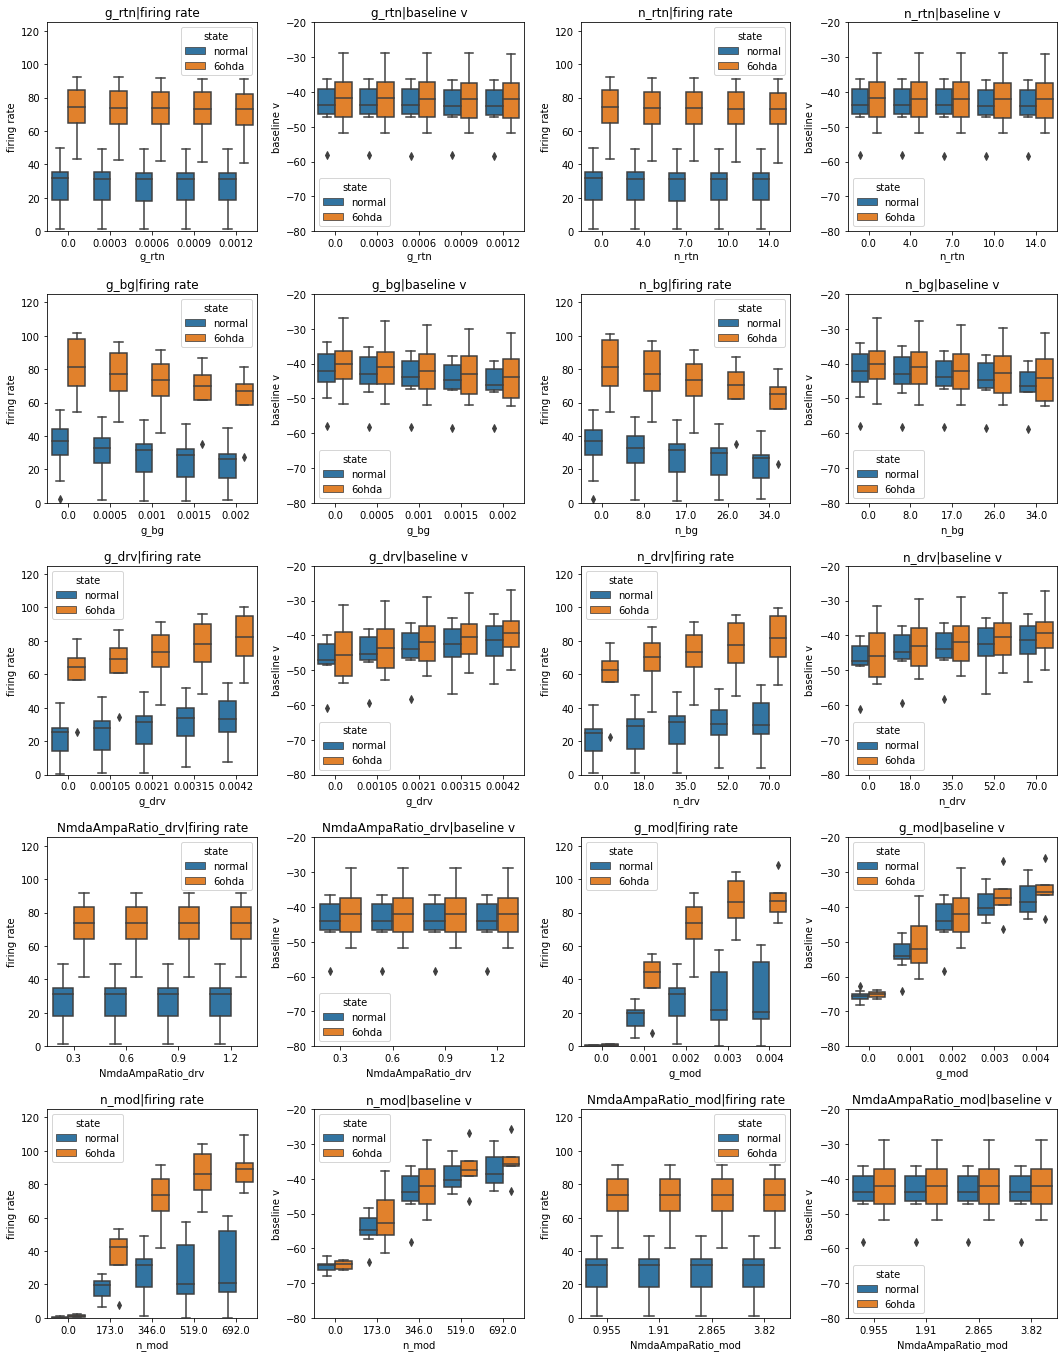

In [35]:
# rows 
nrow = tab.shape[1] - 5

# figure size
fig = plt.figure(figsize=(15, 15 / 4.0 * nrow))

for i, colx in enumerate(tab.drop(['file_object', 'key', 'state', 'firing rate', 'baseline v'], axis=1).columns):
    
    # select the parameter column and drop the rows with NaNs
    tmp = tab[[colx, 'firing rate', 'baseline v', 'state']].dropna()
    
    # plot ap count and baseline
    for j, coly in enumerate(['firing rate', 'baseline v']):
        plt.subplot(nrow, 4, i * 2 + j + 1)
        plt.title('%s|%s' % (colx, coly))
        sns.boxplot(data=tmp, x=colx, y=coly, hue='state')
        plt.ylim([0, 125] if j == 0 else [ -80, -20])

# spacing
plt.tight_layout(pad=1.5)
plt.show()

### How the plots for n_mod and g_mod look so similar?

I made any technical mistake?

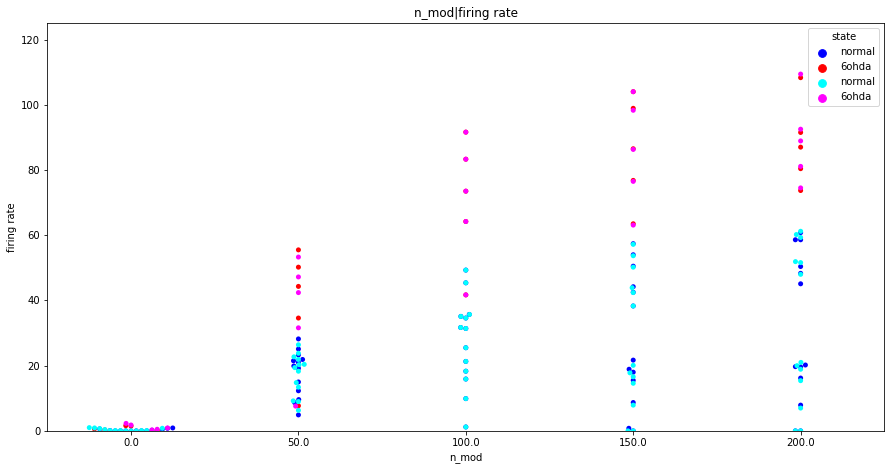

In [47]:
# figure size
fig = plt.figure(figsize=(15, 7.5))
    
# select the parameter column and drop the rows with NaNs
tmp = tab[['g_mod', 'firing rate', 'baseline v', 'state']].dropna()
tmp['g_mod'] = tmp['g_mod'] / 0.002 * 100

# plot ap count
plt.title('%s|firing rate' % 'g_mod')
sns.swarmplot(data=tmp, x='g_mod', y='firing rate', hue='state', palette=['blue', 'red'])
plt.ylim([0, 125])

# select the parameter column and drop the rows with NaNs
tmp = tab[['n_mod', 'firing rate', 'baseline v', 'state']].dropna()
tmp['n_mod'] = tmp['n_mod'] / 346 * 100

# plot ap count
plt.title('%s|firing rate' % 'n_mod')
sns.swarmplot(data=tmp, x='n_mod', y='firing rate', hue='state', palette=['cyan', 'magenta'])
plt.ylim([0, 125])

plt.show()

Not at all.They are very similar but slightly different.

#### Let's compare the traces also.

<Figure size 1080x540 with 0 Axes>

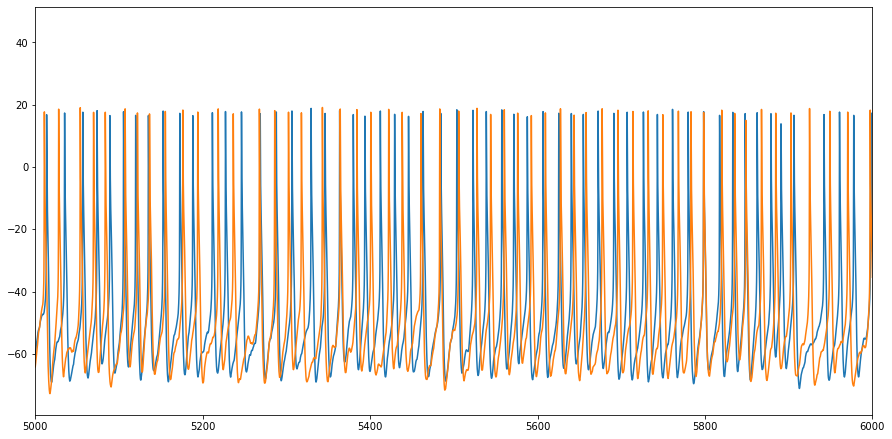

28.2 26.4


<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

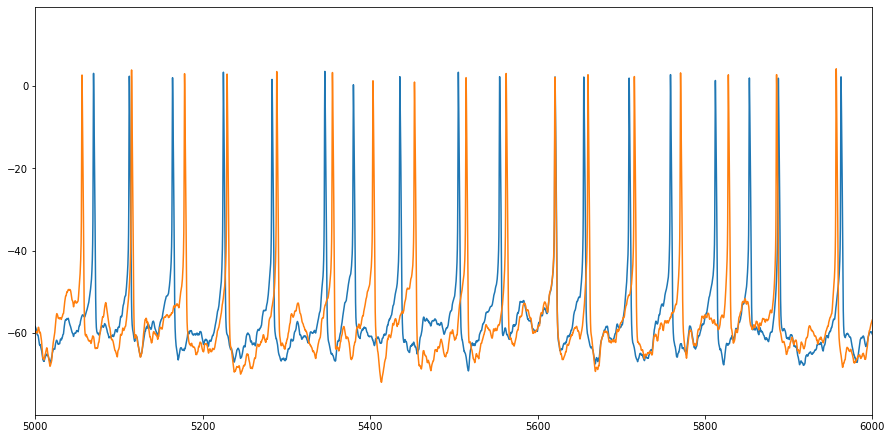

9.6 9.2


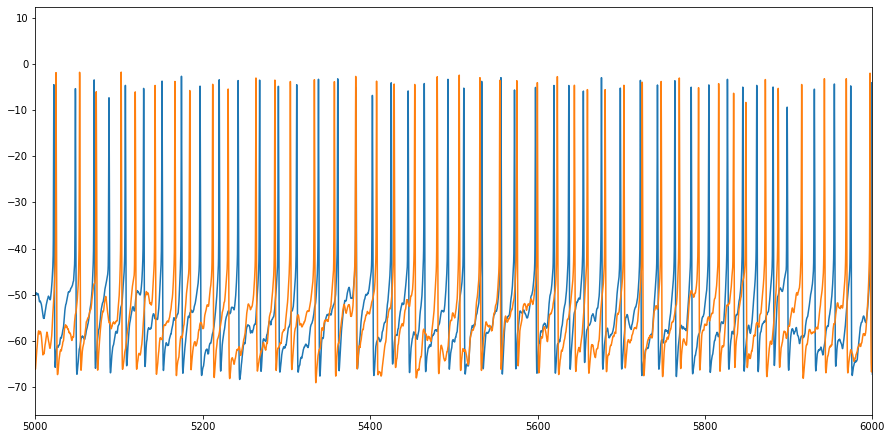

23.3 21.9


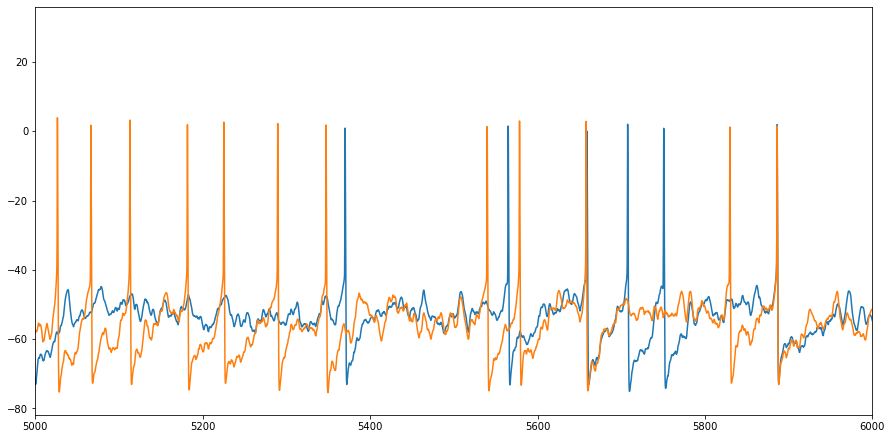

4.9 6.3


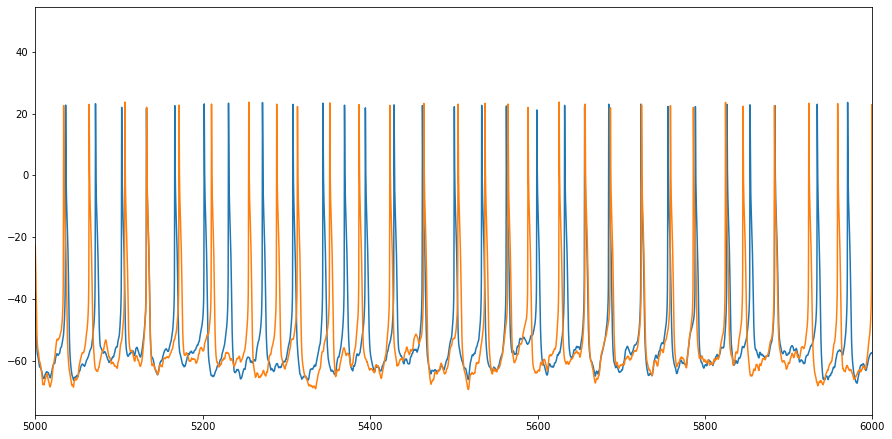

15.0 14.8


<Figure size 1080x540 with 0 Axes>

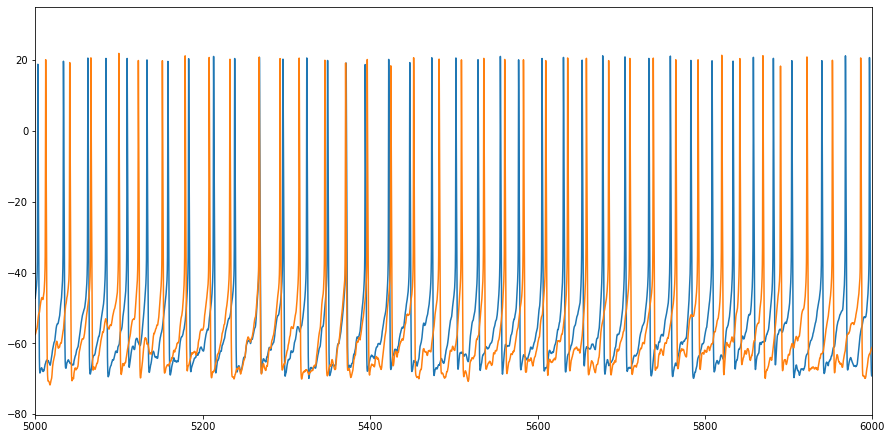

19.2 18.3


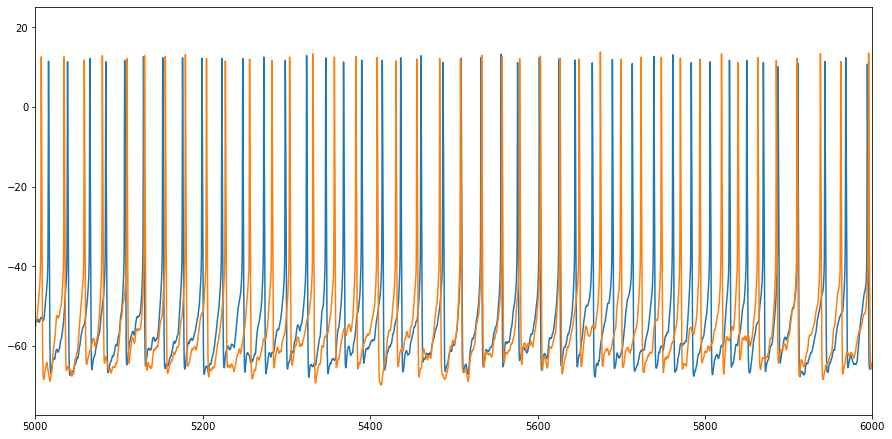

21.5 20.3


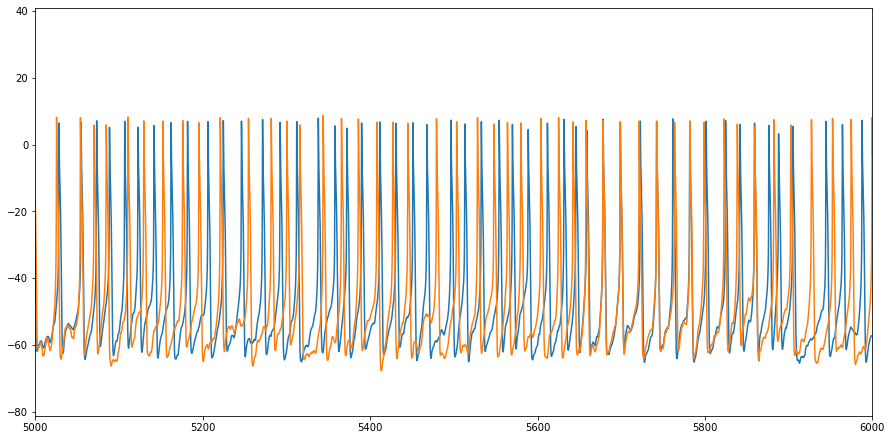

25.1 23.8


<Figure size 1080x540 with 0 Axes>

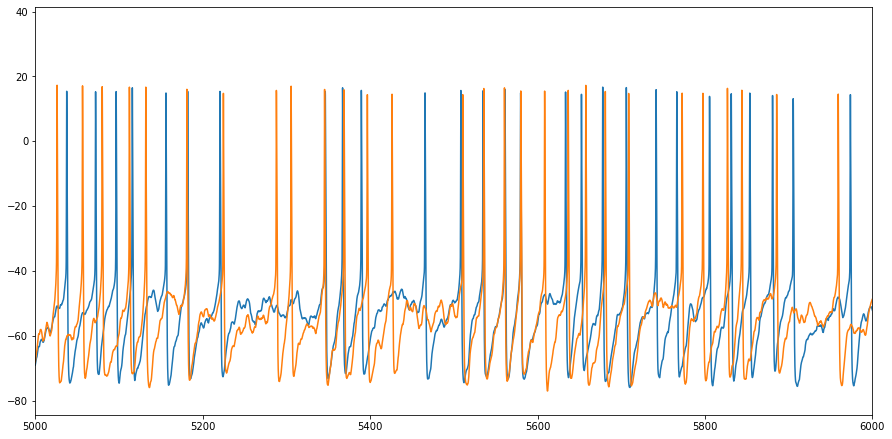

12.3 13.4


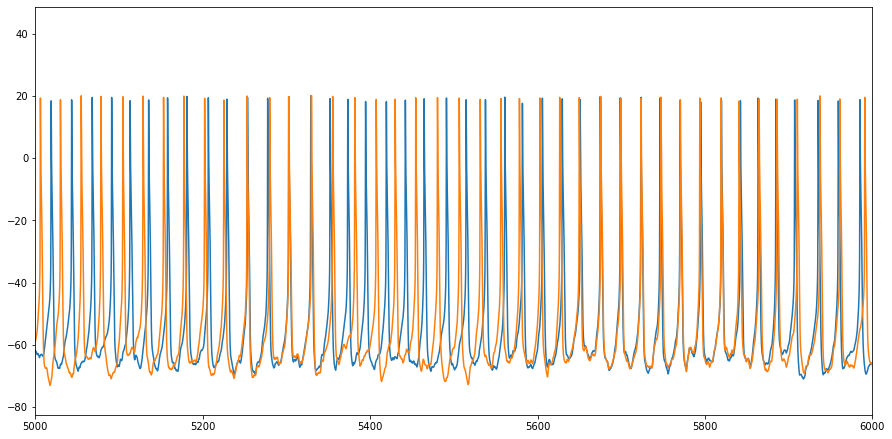

21.0 20.4


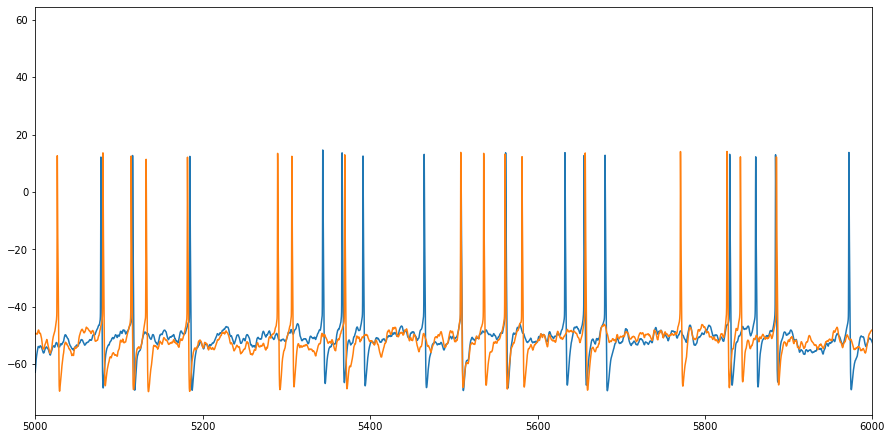

8.7 9.0


<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

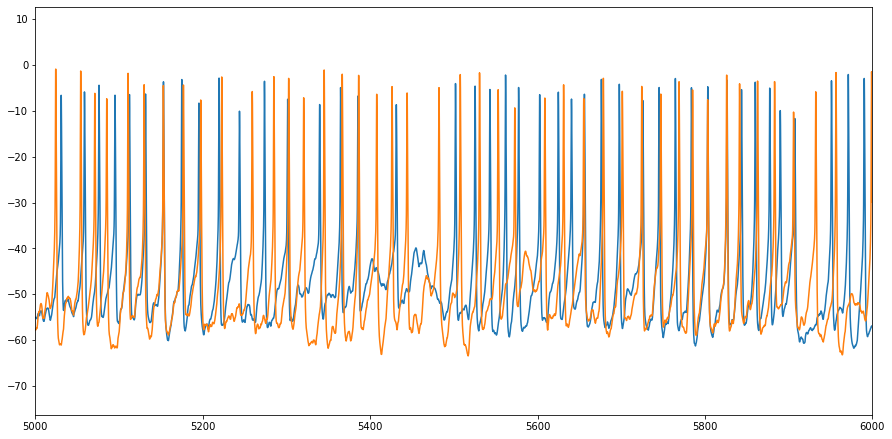

21.9 22.7


<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

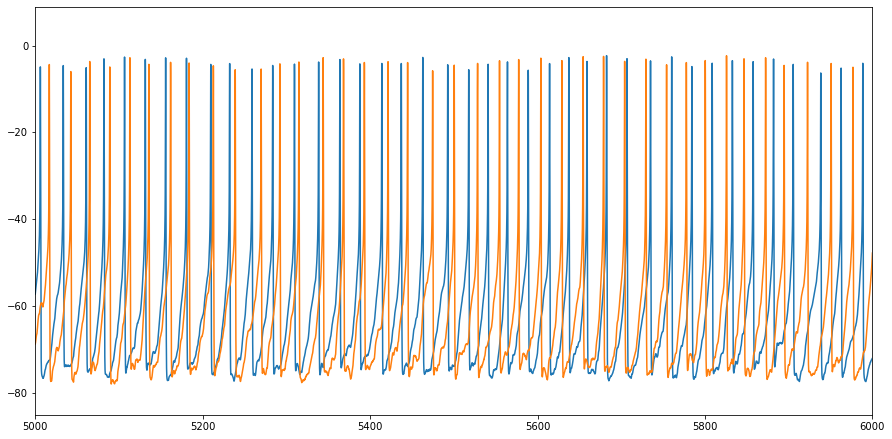

19.9 19.4


In [99]:

for x in range(26):
    try:
        
        k1 = 'output-cellid=%d-seed=0-tstop=15s-g_mod=0.001.somatic.0(0.500000)._ref_v' % x
        k2 = 'output-cellid=%d-seed=0-tstop=15s-n_mod=173.somatic.0(0.500000)._ref_v' % x

        # figure size
        fig = plt.figure(figsize=(15, 7.5))

        # 50% gsyn
        trace1 = tab.loc[tab[tab['key'] == k1].index[0], 'file_object'].read(k1)

        # 50% nsyn
        trace2 = tab.loc[tab[tab['key'] == k2].index[0], 'file_object'].read(k2)

        plt.plot(*trace1)
        plt.plot(*trace2)
        plt.xlim([5000, 6000])
        plt.show()

        print( tab.loc[tab[tab['key'] == k1].index[0], 'firing rate'], tab.loc[tab[tab['key'] == k2].index[0], 'firing rate'])
    except:
        pass

#### Observation.
* RTN does not really sort any effect.
* BG parameters affect significantly the firing rate but barely the baseline voltage.
* DRV *n_syn* and *g_syn* affect significantly the firing rate but barely the baseline voltage, while Nmda-to-Ampa ratio does not play any significant role under these conditions.
* MOD *n_syn* and *g_syn* affect significantly both firing rate and baseline voltage, while its Nmda-to-Ampa ratio does not play any significant role under these conditions.
* For all configurations, baseline voltage appears relatively high, between -50mV and -40mV.

#### Recommendations.
* Dropping RTN parameters and Nmda-to-Ampa ratios for both DRV and MOD when conducting further parameter space explorations.
* The high baseline voltage, as controlled by MOD *n_syn* and *g_syn*, suggest that we should lower these parameters. Given that *n_syn* is somehow constrained to experimental measures of VM neurons, we might decrease the *g_syn*.
* All the parameters were explored between 0% and 200% of control. For all the synaptic inputs, variation of *n_syn* and *g_syn* within the percentual range yield similar values of baseline voltage and firing rate. This gives insight into the integrative properties of our models which may account for some level of linearity.